<a href="https://colab.research.google.com/github/tris-rivers/MST/blob/main/multi_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import and Configure Modules

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# Set content and style path

In [5]:
# content_path = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/content_portraits/keanu.PNG"
# style_path1 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/van_gogh/van_gogh_self_portrait2.jpg"
# style_path2 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/van_gogh/man1.PNG"

# content_path = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/content_portraits/taylor.jpg"
# style_path1 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/van_gogh/lady1.PNG"
# style_path2 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/van_gogh/mousme.jpg"

#### squares start ####

# content_path = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/content/taylor_square.jpg"
# style_path1 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/style/lady1.PNG"
# style_path2 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/style/mousme.jpg"


# content_path = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/content/taylor_square.jpg"
# style_path1 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/style/van_gogh_self_portrait.jpg"
# style_path2 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/style/man3.jpg"

# content_path = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/content/brad_pitt.PNG"
# style_path1 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/style/lady1.PNG"
# style_path2 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/style/mousme.jpg"

# content_path = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/content/brad_pitt.PNG"
# style_path1 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/style/bicentennial.jpg"
# style_path2 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/style/scream.jpg"

content_path = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/content/brad_pitt.PNG"
style_path1 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/style/van_gogh_self_portrait.jpg"
style_path2 = "/content/drive/MyDrive/CSC721M - Neural Style Transfer/images/squares/style/man3.jpg"



# Visualize the Input

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

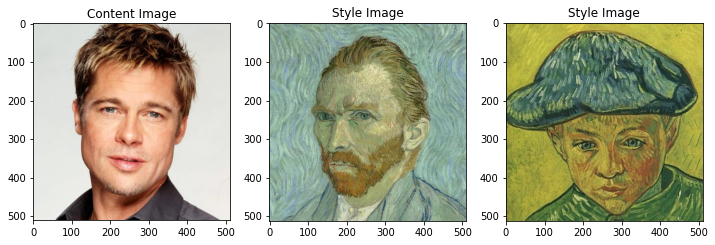

In [8]:
content_image = load_img(content_path)
style_image1 = load_img(style_path1)
style_image2 = load_img(style_path2)

plt.subplot(1, 3, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style_image1, 'Style Image')

plt.subplot(1, 3, 3)
imshow(style_image2, 'Style Image')

# Define Content and Style Representations

## Load VGG-19

In [9]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 0s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [10]:
content_layers = ['block4_conv2'] 

style_layers1 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

style_layers2 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers1 = len(style_layers1)
num_style_layers2 = len(style_layers2)

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [11]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [12]:
style_extractor1 = vgg_layers(style_layers1)
style_outputs1 = style_extractor1(style_image1*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers1, style_outputs1):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 511, 64)
  min:  0.0
  max:  744.53015
  mean:  27.003628

block2_conv1
  shape:  (1, 256, 255, 128)
  min:  0.0
  max:  2588.1526
  mean:  144.9294

block3_conv1
  shape:  (1, 128, 127, 256)
  min:  0.0
  max:  8339.221
  mean:  120.34313

block4_conv1
  shape:  (1, 64, 63, 512)
  min:  0.0
  max:  13297.624
  mean:  508.49792

block5_conv1
  shape:  (1, 32, 31, 512)
  min:  0.0
  max:  2454.4956
  mean:  39.0556



In [13]:
style_extractor2 = vgg_layers(style_layers2)
style_outputs2 = style_extractor1(style_image2*255)


for name, output in zip(style_layers2, style_outputs2):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 510, 64)
  min:  0.0
  max:  705.60004
  mean:  29.138893

block2_conv1
  shape:  (1, 256, 255, 128)
  min:  0.0
  max:  2801.7424
  mean:  143.76173

block3_conv1
  shape:  (1, 128, 127, 256)
  min:  0.0
  max:  7705.247
  mean:  128.00398

block4_conv1
  shape:  (1, 64, 63, 512)
  min:  0.0
  max:  13472.714
  mean:  482.41077

block5_conv1
  shape:  (1, 32, 31, 512)
  min:  0.0
  max:  2225.0537
  mean:  35.707478



# Calculate Style (Gram Matrix)

In [14]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# Extract Style and Content

In [15]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers1, style_layers2, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers1 + style_layers2 + content_layers)
    self.style_layers1 = style_layers1
    self.style_layers2 = style_layers2
    self.content_layers = content_layers
    self.num_style_layers1 = len(style_layers1)
    self.num_style_layers2 = len(style_layers2)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs1, style_outputs2, content_outputs = (outputs[:self.num_style_layers1],
                                                       outputs[:self.num_style_layers2],
                                                       outputs[self.num_style_layers1:])

    style_outputs1 = [gram_matrix(style_output)
                     for style_output in style_outputs1]

    style_outputs2 = [gram_matrix(style_output)
                     for style_output in style_outputs2]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict1 = {style_name: value
                  for style_name, value
                  in zip(self.style_layers1, style_outputs1)}

    style_dict2 = {style_name: value
                  for style_name, value
                  in zip(self.style_layers2, style_outputs2)}

    return {'content': content_dict, 'style1': style_dict1, 'style2': style_dict2}

In [16]:
extractor = StyleContentModel(style_layers1, style_layers2, content_layers)

results = extractor(tf.constant(content_image))

print('Styles1:')
for name, output in sorted(results['style1'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print('Styles2:')
for name, output in sorted(results['style2'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles1:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0063312557
    max:  77794.18
    mean:  397.06525

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  109950.36
    mean:  11753.761

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  246138.52
    mean:  9909.041

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.25563055
    max:  2548791.8
    mean:  162816.97

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  171755.97
    mean:  1364.1993

Styles2:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0063312557
    max:  77794.18
    mean:  397.06525

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  109950.36
    mean:  11753.761

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  246138.52
    mean:  9909.041

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.25563055
    max:  2548791.8
    mean:  162816.97

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  171755.97


# Run Gradient Descent

In [17]:
style_targets1 = extractor(style_image1)['style1']
style_targets2 = extractor(style_image2)['style2']
content_targets = extractor(content_image)['content']

In [18]:
image = tf.Variable(content_image)

In [19]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [37]:
# v1
# style_weight1= 0.01
# style_weight2= 0.1
# content_weight= 10000.0

# v2
# style_weight1= 0.5
# style_weight2= 0.5
# content_weight= 10000.0

# v3
# style_weight1= 0.1
# style_weight2= 0.01
# content_weight= 10000.0

# v4
# style_weight1= 0.5
# style_weight2= 0.0
# content_weight= 10000.0

# v5
style_weight1= 0.0
style_weight2= 0.5
content_weight= 10000.0

In [ ]:
# y1
# style_weight1= 10
# style_weight2= 0
# content_weight= 20000.0

# y2
# style_weight1= 8
# style_weight2= 3
# content_weight= 20000.0

# #y3
# style_weight1= 5
# style_weight2= 5
# content_weight= 20000.0

#y4
# style_weight1= 3
# style_weight2= 8
# content_weight= 20000.0

#y5
# style_weight1= 0
# style_weight2= 10
# content_weight= 20000.0

In [ ]:
# x1
# style_weight1= 10
# style_weight2= 0
# content_weight= 1000.0

# x2
# style_weight1= 8
# style_weight2= 3
# content_weight= 1000.0

# #x3
# style_weight1= 5
# style_weight2= 5
# content_weight= 1000.0

#x4
# style_weight1= 3
# style_weight2= 8
# content_weight= 1000.0

#x5
# style_weight1= 0
# style_weight2= 10
# content_weight= 1000.0

In [38]:
def style_content_loss(outputs):
    style_outputs1 = outputs['style1']
    style_outputs2 = outputs['style2']
    content_outputs = outputs['content']

    style_loss1 = tf.add_n([tf.reduce_mean((style_outputs1[name]-style_targets1[name])**2) 
                           for name in style_outputs1.keys()])
    
    style_loss1 *= style_weight1 / num_style_layers1

    style_loss2 = tf.add_n([tf.reduce_mean((style_outputs2[name]-style_targets2[name])**2) 
                           for name in style_outputs2.keys()])
    
    style_loss2 *= style_weight2 / num_style_layers2

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss1 + style_loss2 + content_loss
    return loss

In [39]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

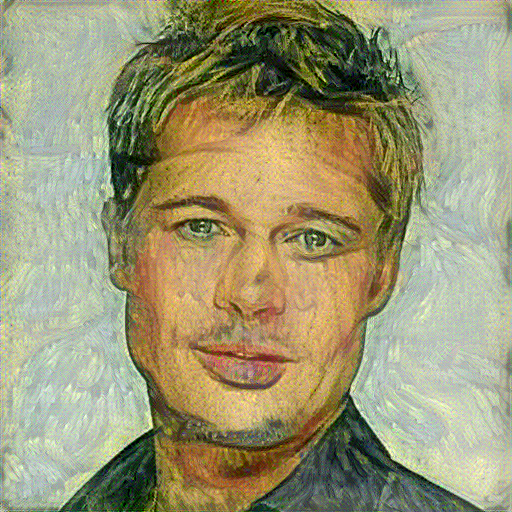

Train step: 1000
Total time: 101.7


In [40]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
# v1 params:
style_weight1= 0.01
style_weight2= 0.1
content_weight= 10000.0

# v2 params:
style_weight1= 0.5
style_weight2= 0.5
content_weight= 10000.0

[reference](https://towardsdatascience.com/mixed-neural-style-transfer-with-two-style-images-9469b2681b54)